<h1> <center>Generating Facies Trends with Seismic and Well data</center> </h1> 

**By**:  David Zhen Yin  
    
**Contact**: [yinzhen@stanford.edu](mailto:yinzhen@stanford.edu) 

**Date**:    Aug 4, 2020

This is the Python package to generate spatial trends of facies proportions. 

The package uses (input) Monte Carlo samples of facies proportions and forward modeled seismic reponse to learn their statistical relathionships. Then with real observed seismic responses, the statistical relationships will produce multiple realizations of facies trends.

The code is demontrated by the data example from Genesis field.

<img src = "src/workflow.jpg" title="Seismic2FaciesTrends" style="width: 500px;"/>
<center>Figure.  General concept of this package</center>  

# Settings

***Prerequisites***
To enable the Package, users need to have Python-3 and the following Python-3 modules installed:

* matplotlib
* numpy
* scipy
* statsmodels
* time
* warnings
* os
* sys

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Input data

Load Monte Carlo samples of prior faices proportions from 1D well modeling: ***fac_prop_pri***

***fac_prop_pri***: 2D array, [n_MCsamples, n_facies]

    'n_MCsamples': total number of Monte Carlos samples
    'n_facies': total number of facies. 
    In this example, 'n_facies=4'. They are: 0 - Massive Sand, 1 - Background Shale, 2-Thinbed, 3 - Margin silt

In [2]:
fac_prop_pri = np.load('data/input/facies_prop_mc.npy')

Load samples of forwarded seismic responses corresponding to the prior facies proportions: ***seis_pri***

***seis_pri***: 1D array, [n_MCsamples]

In [3]:
seis_pri = np.load('data/input/seis_amp_mc.npy')

Load real observed seismic map: ***SeisObs_map***
 
***SeisObs_map***: 2D array, [n_xdim, n_ydim]
    
    n_xdim, n_ydim are dimensions of the seismic map in x and y direction. It will be the dimension of final generated trend maps. 

In [4]:
SeisObs_map = np.load('data/input/seis_obs_map.npy')

**Visualize the input data**

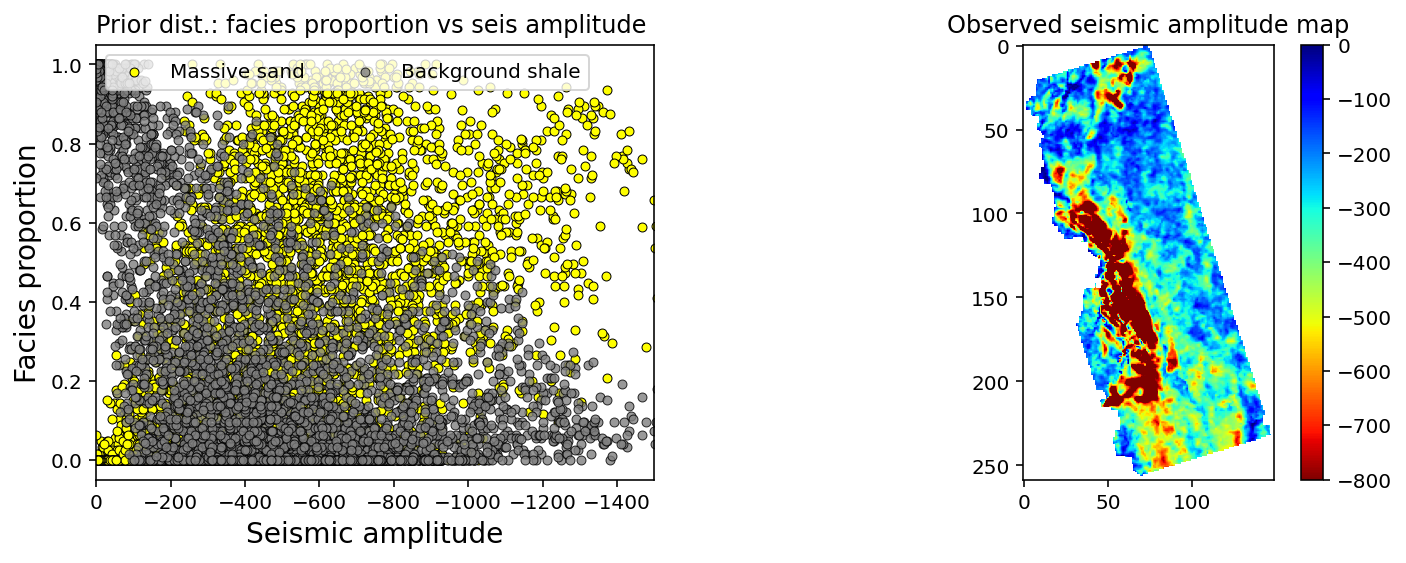

In [5]:
from src.viz_Genesis_input import viz_Genesis_input
viz_Genesis_input(fac_prop_pri, seis_pri, SeisObs_map) 

## KDE

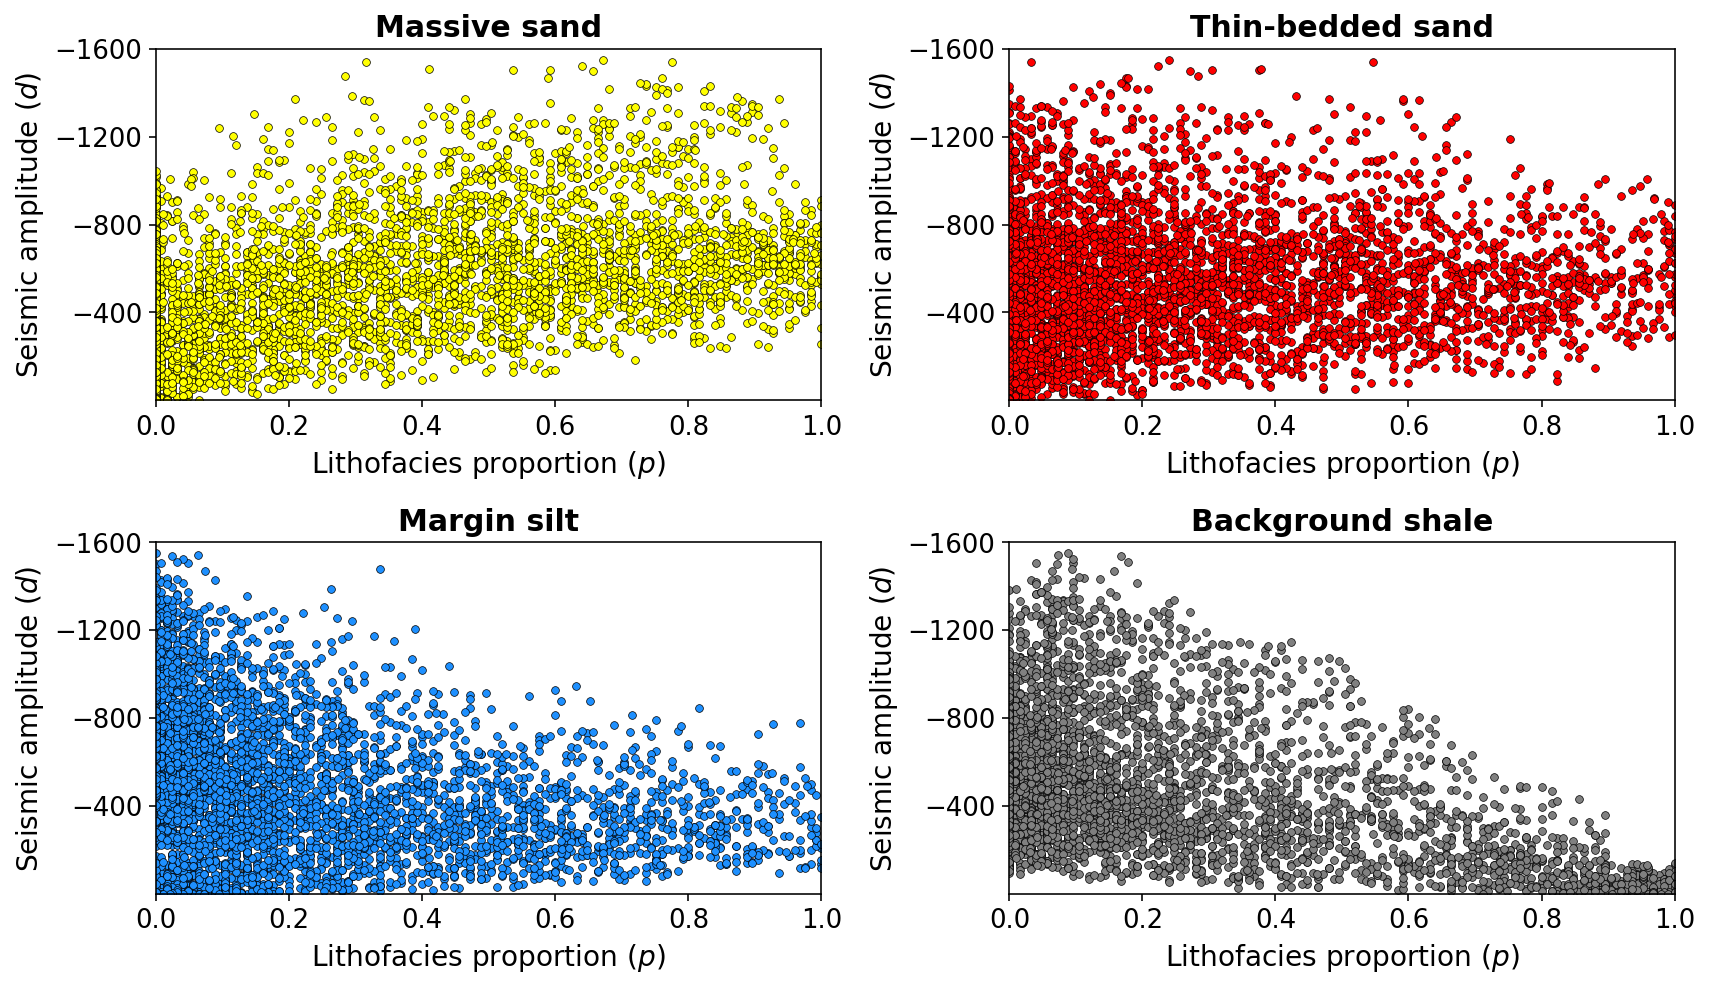

In [107]:
plt.figure(figsize=(12,7))
color=['yellow', 'grey', 'red', 'dodgerblue']
facies = [0, 2, 3, 1]
facies_name = ['Massive sand', 'Background shale', 'Thin-bedded sand', 'Margin silt']
subplt = 1
for i in facies:
    plt.subplot(2,2,subplt)
    plt.scatter(fac_prop_pri[:,i],seis_pri,  c = color[i], linewidths=0.35, edgecolors= 'k', s = 15)
    # sns.kdeplot(seis_pri, fac_prop_pri[:,i],  shade=True, cbar=True, cmap='jet', vmax=0.008)
    plt.gca().invert_xaxis()
    plt.ylim(0, -1600), plt.xlim(0, 1)
    plt.ylabel('Seismic amplitude ($d$)', fontsize=14)
    plt.xlabel('Lithofacies proportion ($p$)', fontsize=14)
    plt.title(facies_name[i], fontsize=15, weight='bold')
    plt.yticks([-400, -800, -1200, -1600], fontsize=13), plt.xticks(fontsize=13)
    subplt +=1
plt.tight_layout()

Define total realization number of facies trends to generate

In [6]:
n_trend_reals = 200 # int

# Metropolis-Hastings 

Run Metropolis-Hastings under Dirichlet to sample posterior facies proportions

##  step 1. Estimate the Dirichlet distribution of prior facies proportions (via maximum likelihood estimation).

In [5]:
from src.direchlet_mle import direchlet_mle
alpha_pri = direchlet_mle(fac_prop_pri, tol=1e-4, maxiter=100000)

In [117]:
direchlet_mle(fac_prop_pri[seis_pri>-10], tol=1e-4, maxiter=100000)

array([ 3.09114004, 63.50075402, 11.4985063 ,  3.8742447 ])

## step 2. Discretize seismic observations to save runing time

In [9]:
seisobs_max, seisobs_min = -2090, 0
discre_stp = 20
seis_obs_dis = np.arange(seisobs_max, seisobs_min, discre_stp)

## Step 3. Run Metropolis-Hastings

In [8]:
from src.run_MH import run_MH
post_smpls_all = run_MH(fac_prop_pri, seis_pri, alpha_pri, seis_obs_dis, Maxstep=25000, Jumpwidth=0.05)

Estimated Running Time:24.47 minutes


**Check Metropolis-Hastings results**

Test

In [912]:
test = dir_mh_sampling(fac_prop_pri, seis_pri, alpha_pri, [-1390], maxstep=15000, delta_left=0.4, delta_right=10)

(0.0, 0.9)

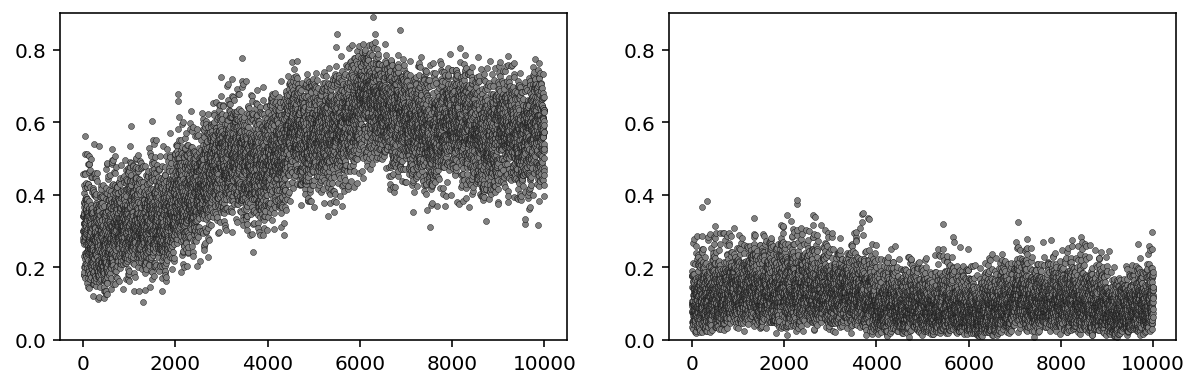

In [918]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(test[0][5000:,0, 0], '.', markeredgecolor = 'k', \
         markerfacecolor = 'grey', markeredgewidth = 0.2)
plt.ylim(0,0.9)
plt.subplot(122)
plt.plot(test[0][5000:,0,3], '.', markeredgecolor = 'k', \
         markerfacecolor = 'grey', markeredgewidth = 0.2)
plt.ylim(0,0.9)

In [919]:
np.save('MH_samples_dosb_(-1390)_v4',test[0][:10000])

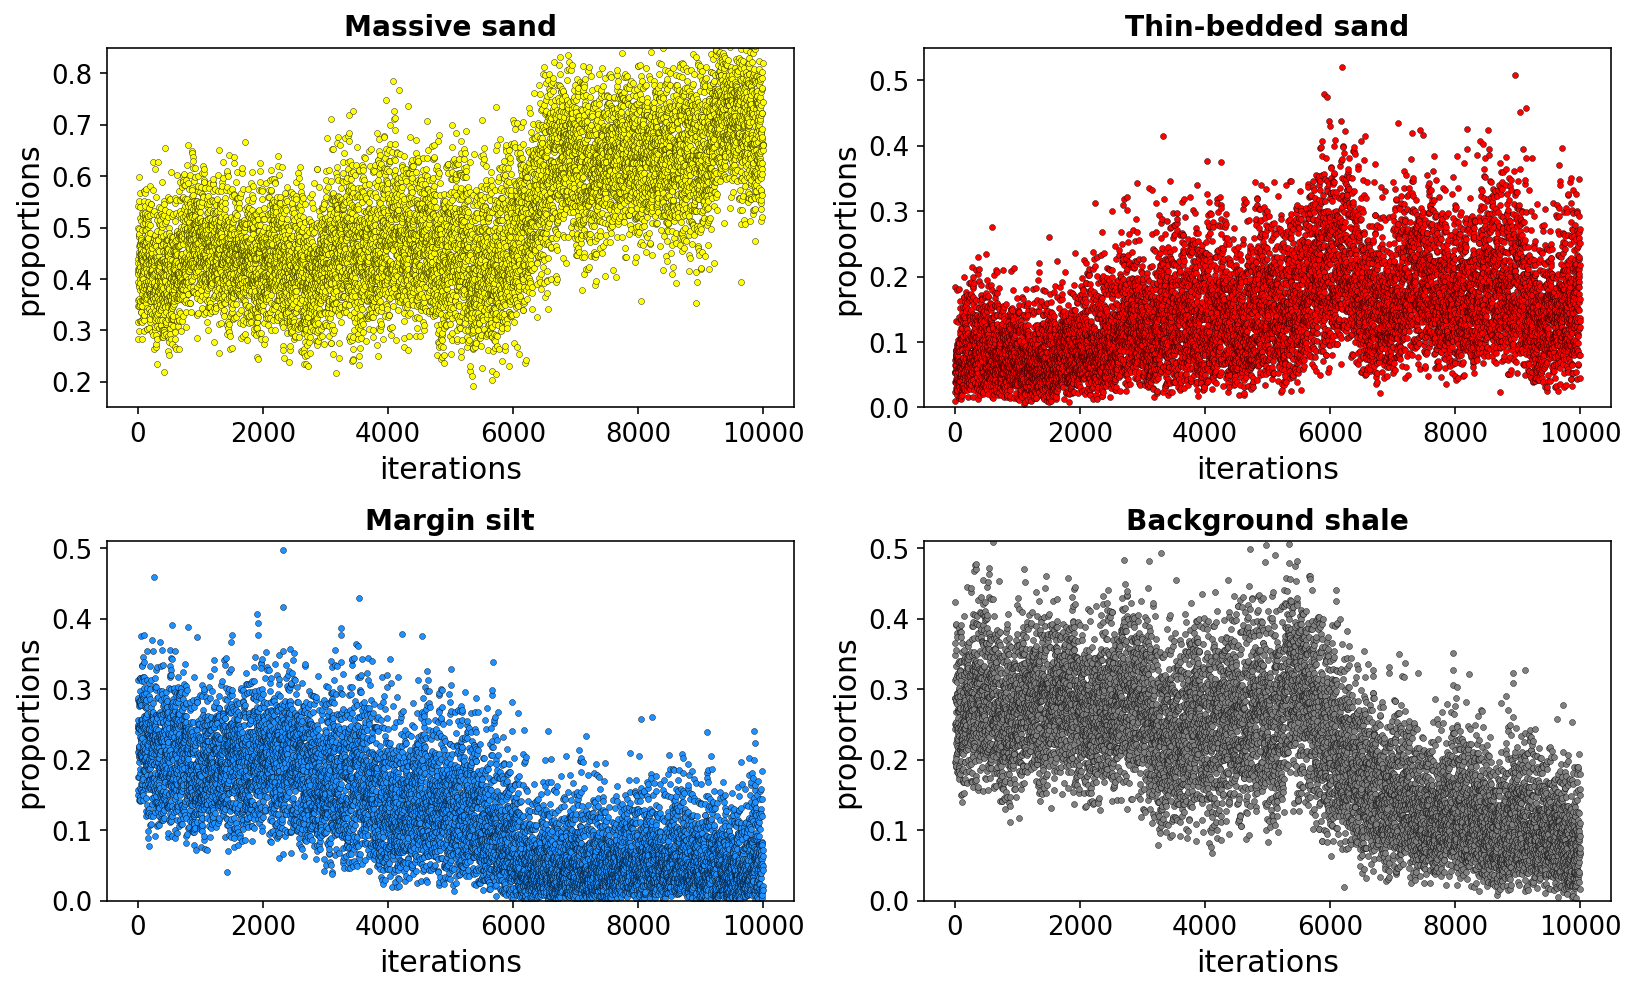

In [6]:
data = np.load('MH_samples_dosb_(-1390)_v2.npy')

plt.figure(figsize=(11.5, 7))
plt.subplot(221)
plt.title('Massive sand', fontsize=14, weight='bold')
plt.plot(data[:,0, 0], '.', markeredgecolor = 'k', \
         markerfacecolor = 'yellow', markeredgewidth = 0.2)
plt.xlabel('iterations', fontsize=15), plt.ylabel('proportions', fontsize=15)
plt.ylim(0.15,0.85), plt.xticks(fontsize=13), plt.yticks(fontsize=13)
plt.subplot(222)
plt.title('Thin-bedded sand', fontsize=14, weight='bold')
plt.plot(data[:,0,2], '.', markeredgecolor = 'k', \
         markerfacecolor = 'red', markeredgewidth = 0.2)
plt.xlabel('iterations', fontsize=15), plt.ylabel('proportions', fontsize=15)
plt.ylim(0,0.55), plt.xticks(fontsize=13), plt.yticks(fontsize=13)
plt.subplot(223)
plt.title('Margin silt', fontsize=14, weight='bold')
plt.plot(data[:,0,3], '.', markeredgecolor = 'k', \
         markerfacecolor = 'dodgerblue', markeredgewidth = 0.2)
plt.xlabel('iterations', fontsize=15), plt.ylabel('proportions', fontsize=15)
plt.ylim(0.00,0.51), plt.xticks(fontsize=13), plt.yticks(fontsize=13)
plt.subplot(224)
plt.title('Background shale', fontsize=14, weight='bold')
plt.plot(data[:,0,1], '.', markeredgecolor = 'k', \
         markerfacecolor = 'grey', markeredgewidth = 0.2)
plt.xlabel('iterations', fontsize=15), plt.ylabel('proportions', fontsize=15)
plt.ylim(0.00,0.51), plt.xticks(fontsize=13), plt.yticks(fontsize=13)
plt.tight_layout()

In [909]:
import scipy.stats as stats
import statsmodels.api as sm
def dir_mh_sampling(MC_c_prop, MC_seis, ini_alpha, seis_obs, maxstep = 1000, delta_left=0.2, delta_right=0.2):
    
    '''
    This is Metropolis-Hastings (MH) algorithm to sample posterior facies proportion under Dirichlet Dist. 
    Input Variables - 
        MC_c_prop: Monte Carlos samples of facies proportions, 2D array, [n_MCsamples, n_facies]
        
        MC_seis: Monte Carlos samples of forward modeled seismic responses corresponding to MC_c_prop, 
                1D array, [n_MCsamples]
        
        ini_alpha: Dirichlet concentration parameters of the input MC_c_prop. 
        
        seis_obs: Real observed seismic value, 1 list item, format - [seisobs_val]
        
        maxstep: optional, maximum steps of MH sampling, default = 10,000
        
        jumpwidth: optional, jump width of beta, default = 20%
        
    Output 
        c_pos_all: all the posterior facies proportion samples from MH
        beta_all: all the posterior Dirichlet concentration parameters from MH
    '''
    
    c_dim = MC_c_prop.shape[1]
    MC_c_seis = np.c_[MC_c_prop[:,:c_dim-1], MC_seis]
    
    # KDE of the joint distribution between Monte Carlo samples of seismic ('seis') and facies proportion ('c')
    endog_dim = 'c'*1
    indep_dim = 'c'*(c_dim-1)
    kde_seis_c = sm.nonparametric.KDEMultivariateConditional(endog=MC_c_seis[:,:c_dim-1], \
                                                             exog=MC_c_seis[:,c_dim-1:], \
                                                             dep_type=indep_dim, indep_type=endog_dim, bw='normal_reference')
    
    '''Initial state''' 
    beta = np.copy(ini_alpha)
    c_pos = np.random.dirichlet(beta, 1)
    c_pos_all = []
    c_pos_all.append(c_pos)
    
    beta_all = []
    beta_all.append(beta)
    
    '''calculate pdf of initial c_pos and the proposed c_star'''
    
    p_seis_cpos = kde_seis_c.pdf(endog_predict=c_pos[0, :c_dim-1], exog_predict=seis_obs)

    dir_cpos = stats.dirichlet.pdf(c_pos[0,:], beta)
    
    dir_AlphaHat_cpos = stats.dirichlet.pdf(c_pos[0,:], ini_alpha)
    
    '''determine delta '''
#     delta = jumpwidth * ini_alpha
    
    '''define the proposed uniform distribution f(beta)'s lower and upper bound'''
    Jalpha_max = ini_alpha*(1+delta_right)
        
    Jalpha_min = ini_alpha*(1-delta_left)
    
    '''ensure each element of alpha >0'''
    Jalpha_min[Jalpha_min<=0] = 0.1 
    
    itr=0
    
    t=1
    Beta_reject = True
    test = []
    reject_n = 0
    
    while t<maxstep:
#     for i in range(maxstep):
        
        try:
#             '''sample from proposed posterior'''
#         if Beta_reject:
            if reject_n > 4:
                if itr>60 :
                    pre_beta = np.copy(np.asarray(beta_all))
    #                 beta = np.mean(pre_beta,axis=0)
                    beta = np.random.uniform(Jalpha_min, Jalpha_max, 4)
    #                 beta = np.copy(beta_all[-1])
                    itr=0
                for i in range(len(beta)):
                    '''seach best beta gradually'''
                    beta[i] = np.random.uniform(0.97*beta[i], 1.03*beta[i])
                    if beta[i]<Jalpha_min[i]:
                        beta[i]=Jalpha_min[i]
                    elif beta[i]>Jalpha_max[i]:
                        beta[i]=Jalpha_max[i]
                        
                        
#             else: 
#                 beta = np.random.uniform(Jalpha_min, Jalpha_max, 4)  
            c_star = np.random.dirichlet(beta, 1)
            dir_cstar = stats.dirichlet.pdf(c_star[0,:], beta)
            dir_AlphaHat_p_star =  stats.dirichlet.pdf(c_star[0,:], ini_alpha)

        
        except:
            next
            
        '''calculate p(seis|c)'''

        p_seis_cstar = kde_seis_c.pdf(endog_predict=c_star[0, :c_dim-1], exog_predict=seis_obs)

        
        '''calculate acceptance ratio'''
        # D(P*, alpha_hat)
#         r=0.5
#         r = (p_seis_cstar*dir_AlphaHat_p_star)/(p_seis_cpos*dir_AlphaHat_cpos)
        r = (p_seis_cstar*dir_AlphaHat_p_star*dir_cstar)/(p_seis_cpos*dir_AlphaHat_cpos*dir_cpos)
#         r = (p_seis_cstar*dir_cstar)/(p_seis_cpos*dir_cpos)
#         r = (p_seis_cstar*dir_AlphaHat_p_star*dir_cpos)/(p_seis_cpos*dir_AlphaHat_cpos*dir_cstar)

        u = np.random.uniform(0, 1, 1)

        '''Obstain posterior sample'''
        
#         print('Process-> {:1.2%}'.format((i+1)/maxstep), end='\r')
        if r>u: # accept
        
            c_pos = c_star
            c_pos_all.append(c_pos)
            
            dir_cpos = dir_cstar
            dir_AlphaHat_cpos = dir_AlphaHat_p_star
            p_seis_cpos = p_seis_cstar
            beta_all.append(np.copy(beta))
            
#             beta_post = beta
            Beta_reject = False
            t=t+1
#             print(Beta_reject)
            print('Progress -> {:1.1%}'.format(t/maxstep), end='\r')
            itr=0
            reject_n = 0
        else:
            Beta_reject = True
            test.append(np.copy(beta))
            itr = itr + 1
            reject_n = reject_n + 1
#             if reject_n>500:
#                 print(beta)
                
           
    c_pos_all = np.asarray(c_pos_all)
    beta_all = np.asarray(beta_all)
    
    return c_pos_all, beta_all, test

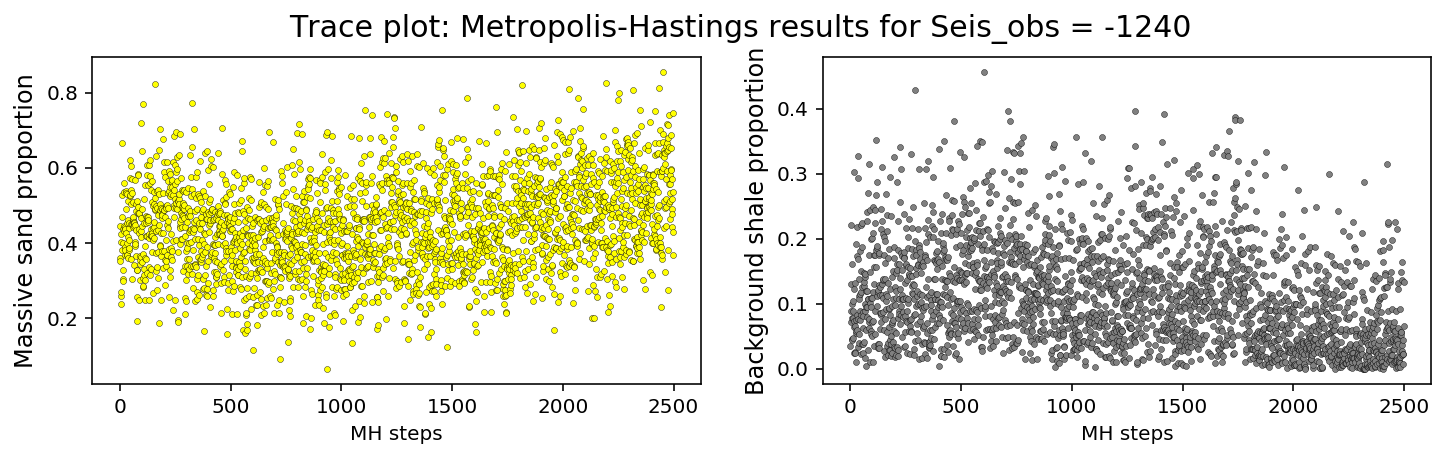

In [30]:
from src.check_Genesis_MH_results import check_Genesis_MH_results
# randomly provide a observed seismic responses
seis_obs = -1240
check_Genesis_MH_results(seis_obs, post_smpls_all, seis_obs_dis)

## step 4. Save posterior facies proportions samples

In [11]:
# save the last 2500 posterior samples
save_stp = 2500
post_prop_save = []
for i in range(len(post_smpls_all)):
    post_prop_save.append(post_smpls_all[i][-save_stp:,:])
post_prop_save = np.asarray(post_prop_save)
np.save('data/output/post_prop_smpls', post_prop_save)

# P-field simulation of faices trend

In [3]:
# Load P-field maps, generated by SGSim
Pfields_smpls = np.load('data/input/P_fields_smpls.npy')
# Pfields_smpls:[n_samples, n_xdim, n_ydim]

# Load the previous saved posterior facies proporstions from MH. 
post_prptn_smpl = np.load('data/output/post_prop_smpls.npy')

**NB:** The P-field maps are generated using the opensource SGSim code from Prof. Michael J. Pyrcz (link: https://github.com/GeostatsGuy/GeostatsPy). If you need the adapted version for Genesis field, please let me know. 

In [13]:
# Step 1. Calculate empirical CDF of posterior proportions for P-field simulation
from src.cal_emp_cdf import cal_emp_cdf
prptn_smpl_cdf = cal_emp_cdf(post_prptn_smpl)
Seis_prptn_cdf = [seis_obs_dis, prptn_smpl_cdf]

In [14]:
# Step 2. Perform P-field simulation to generate facies trends. 
from src.gen_trends_Psim import gen_trends_Psim
facies_trends = gen_trends_Psim(SeisObs_map, Pfields_smpls, Seis_prptn_cdf, n_trend_reals)
np.save('./data/output/facies_trends', facies_trends)

Estimated Running Time:23.92 minutes
Progress-> 100.0%


# Visualize facies trends

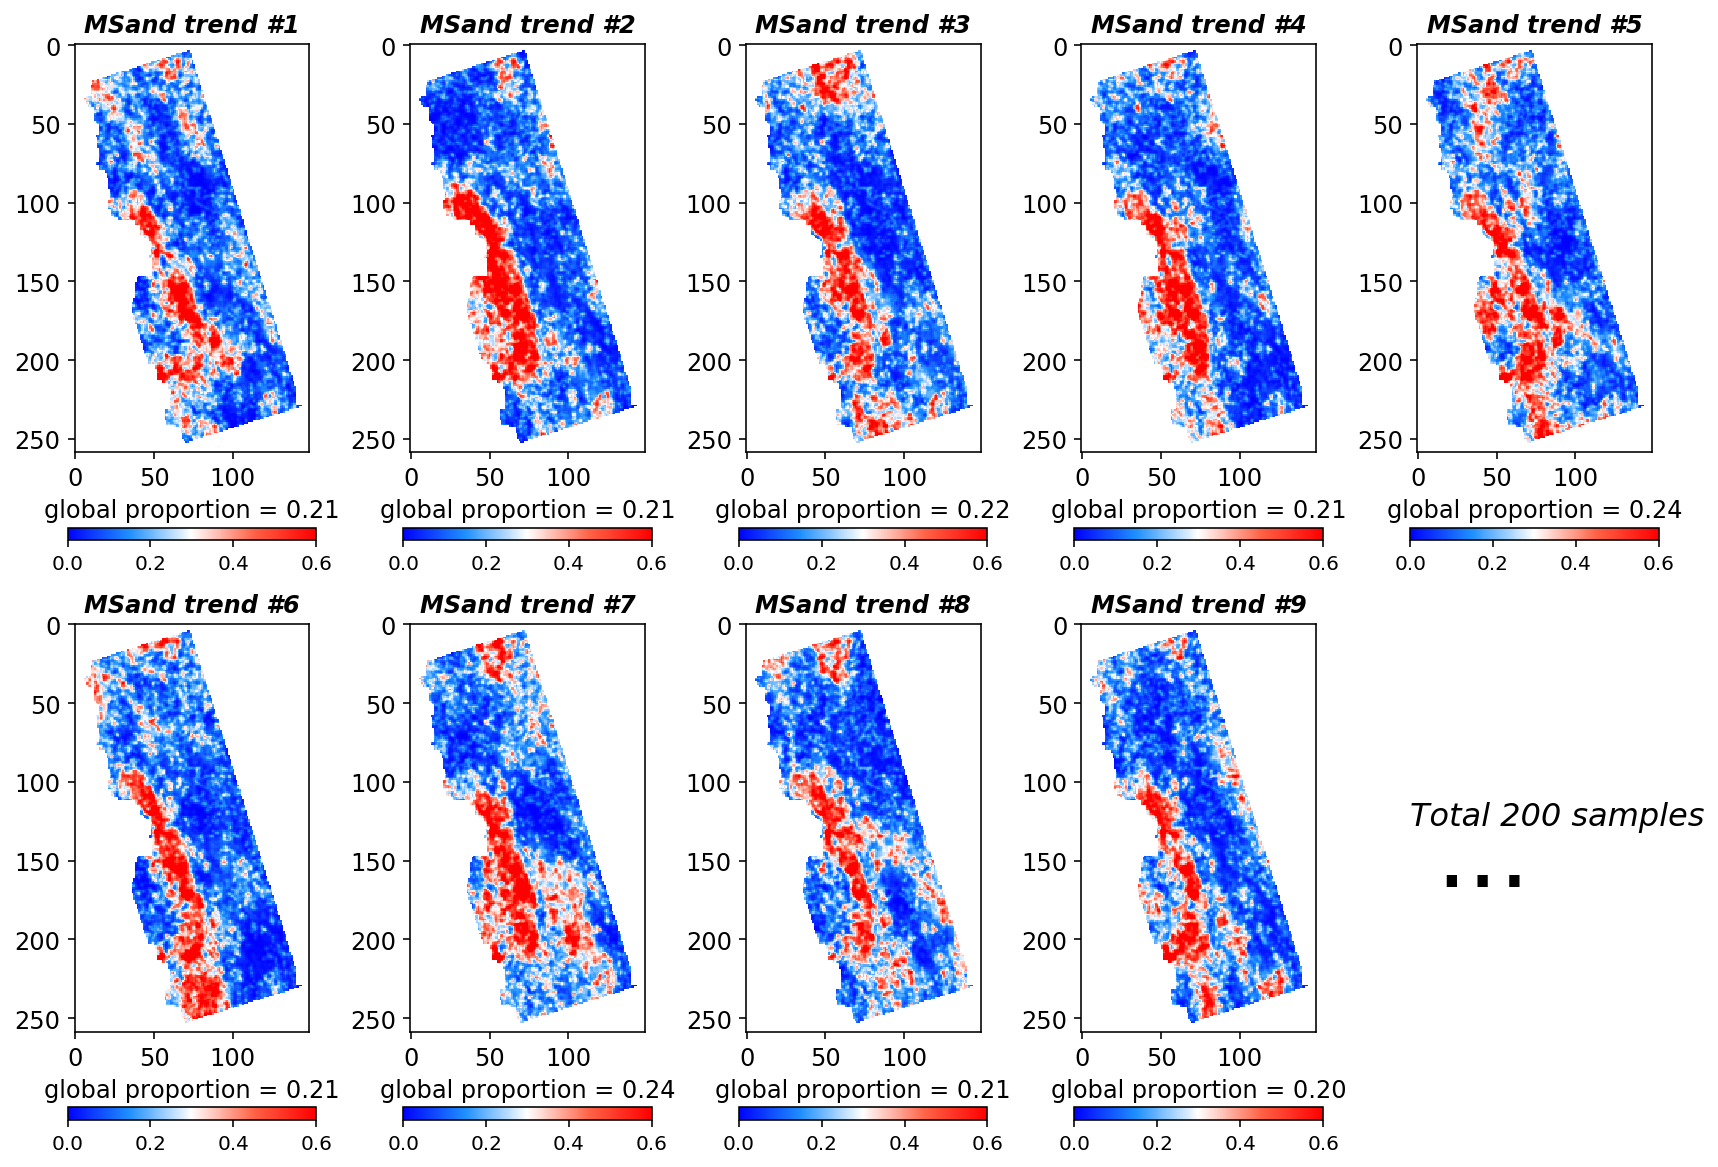

In [6]:
from src.trend_samples_vis import trend_samples_vis

facies_trends = np.load('./data/output/facies_trends.npy')
fac_ = 0
# 0-MSand (massive sand), 1-Bkgrnd (background shale), 2-TSand (Thinbed sand), 3-CMargin (channel margin)
fac_name = ['MSand', 'Bkgrnd', 'TSand','CMargin']

trend_samples_vis(facies_trends[:,:,:,fac_], fac_name[fac_])